In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py


#ML packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from itertools import groupby

from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model, load_model, Sequential, save_model
from tensorflow. keras.layers import Dense, Activation, Dropout, Input,  TimeDistributed, GRU, Masking, LSTM
from tensorflow.keras.utils import to_categorical


In [32]:
#load custom functions

#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 12 2021
@author: cechava
"""
from itertools import groupby
import numpy as np
import pandas as pd
import scipy
import scipy.signal

#to visualize 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")


#to load files
import os
import h5py

#ML packages
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import f1_score,make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE


from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model, load_model, Sequential, save_model
from tensorflow. keras.layers import Dense, Activation, Dropout, Input,  TimeDistributed, GRU, Masking, LSTM
from tensorflow.keras.utils import to_categorical


# ~~~~~~~ DATA WRANGLING FUNCTIONS ~~~~~~~
def get_gesture_times(data_df):
    """
    Get start times, end times, and event labels of each block of time with a given label
    
    Args:
        data_df: dataframe with columns for 'class' and 'time' 
            
    Returns:
        start times, end times, and event labels: 1-d numpy arrays 
        
    """

    #get start indices of each condition 
    
    #taking advantage that every gesture is preceded by a period with 'undefined' class label (value 0)
    start_idxs = np.hstack([0,np.where(np.abs(np.diff(data_df['class']))>0)[0]+1])
    
    #end indices correspond to just before the start of the next condition
    end_idxs = np.hstack((start_idxs[1:]-1,data_df.time.size-1))
    

    #create arrays with start times and class labels for each hand gesture
    start_times = data_df.time[start_idxs].values
    end_times = data_df.time[end_idxs].values
    event_labels = data_df['class'][start_idxs].values
    
    return start_times, end_times, event_labels

def get_steady_samp_rate_data(data_df):
    
    """
    Resample time series data for a steady sampling rate by performing linear interpolation
    between missing samples
    
    Args:
        data_df: dataframe with a 'time' column and timeseries of interest on other columns
            
    Returns:
        data_df: dataframe with interpolated 
    """
    
    #retrieve time value
    time = data_df.time.values
    #define time points on which we want to interpolate (i.e., a sample every ms)
    time_new = np.arange(time[0],time[-1]+1,1)
    
    #create separate dataframe with new time points and set these as index
    steady_time_df = pd.DataFrame({'time_constant':time_new})
    steady_time_df = steady_time_df.set_index('time_constant')
    
    #set time coulumn of original dataframe to index
    data_df = data_df.set_index('time')

    #perform a right join with the steady time dataframe then linearly interpolate missing values
    data_df = data_df.join(steady_time_df, how = 'right')
    data_df = data_df.interpolate().reset_index().rename(columns={'time_constant':'time'})
    
    return data_df

def butter_bandpass_filter(input_signal, lowcut, highcut, fs, order=4, axis = -1):
    #lowcut = lower bound of desired freq band
    #hicut = upperbound bound of desired freq band
    #fs = sampling rate
    #order = order of filter
    #axis = axis of data matrix on which to apply filters

    low = float(lowcut)# / nyq
    high = float(highcut)# / nyq
    b, a = scipy.signal.butter(order, [low, high],fs = fs, btype='band')
    
    output_signal = scipy.signal.filtfilt(b, a, input_signal,axis = axis)
    
    return output_signal
    
def get_window_features(signal):
    #signal: EMG signal matrix with dims time x channels
    #return: Mean Absolute Value and Wavelength features for each channel

    MAV = np.mean(np.absolute(signal),axis = 0) #Mean Absolute Value

    WL = np.sum(np.absolute(np.diff(signal,axis = 0)),axis = 0) #Wavelength
    
    return MAV, WL

def window_and_get_features(parsed_df,win_size,step):
    """
    Compute features (Mean Absolute Value and Wavelength) for time series segments with given length 
    and amount of overlap
    
    Args:
        parsed_df: dataframe containing timeseries data for each block. expects a 'Block' column
        and the channel data in the first columns of dataframe
        
            
    Returns:
        feat_matrix: 2D numpy array of size [number of segments, number of channels * number of features]
        target_labels: 1D numpy array with class label for each segment
        window_tstamps: 1D numpy array with timestamp for each timeseries segment used to compute features
        block_labels: 1D numpy array indicating block provenance of each segment (useful for RNN data prep)
    """
    #set empty lists
    feat_matrix = []
    target_labels = []
    window_tstamps = []
    block_labels = []

    #get number of channels
    nchannels = np.sum(['Channel' in col_name for col_name in parsed_df.columns])

    for block in parsed_df.Block.unique():
        #get relevant subset of dataframe
        block_df = parsed_df.loc[parsed_df.Block == block]

        #extract relevant info
        block_data_matrix = block_df.iloc[:,0:8].values
        block_class = block_df['Class'][0]
        tstamps = block_df['Time'].values

        #compute desired features over segments of the data
        for win_start_idx in range(0, block_df.shape[0], step):
            win_end_idx = win_start_idx + win_size
            if win_end_idx< block_df.shape[0]: #exclude window if not enough timepoints before end of block

                #compute features within this segment
                MAV, WL = get_window_features(block_data_matrix[win_start_idx:win_end_idx,:])

                #append info to matrices
                feat_matrix.append(np.hstack((MAV,WL)))
                target_labels.append(block_class)
                window_tstamps.append(np.mean([tstamps[win_start_idx],tstamps[win_end_idx]]))
                block_labels.append(block)
                
    return np.array(feat_matrix), np.array(target_labels), np.array(window_tstamps), np.array(block_labels)





def parse_data_blocks(start_times, end_times, event_labels, data_matrix, tstamps, pre_tpts = 0, exclude_class=[]):
    """
    Function to parse timeseries into blocks corresponding to each event. 
    Returns a dataframe - seemed most convenient given variable length of event blocks
    
    Args:
        start_times: 1D numpy array with start times of event blocks
        end_times: 1D numpy array with start times of event blocks
        event_labels: 1D numpy array with start times of event blocks
        data_matrix: 2D numpy array with of dimension [ntimepoints, nchannels] containing signal values
        pre_tpts: how many timepoints before event onset to include(int)
        exclude_class: list with class labels to exclude in parsing blocks
            
    Returns:
        parsed_df: dataframe with parsed data
        block_length: 1D numpy array with timepoints in each event block
    """
    
    parsed_df = []

    #note characterisitcs of matrix
    ntpts, nchannels = data_matrix.shape

    parsed_df = []
    block_lengths = []
    for block,c in enumerate(event_labels):
        if c not in exclude_class:
            # get relevant indives to get dara from matrix
            start_idx = np.where(tstamps>start_times[block])[0][0]
            end_idx = np.where(tstamps>=end_times[block])[0][0]

            # append block length to list
            block_lengths.append(end_idx-start_idx)

            # get timestamps relative to event onset
            t_ase = np.arange(-pre_tpts,end_idx-start_idx)

            # put data matrix values into a dataframe
            block_df = pd.DataFrame(data_matrix[start_idx-pre_tpts:end_idx,:], columns = ['Channel_%i'%(c+1) for c in range(nchannels)])

            # add relevant value columns
            block_df['Block'] = block
            block_df['Class'] = c 
            block_df['Time_ASE'] = t_ase
            block_df['Time'] = np.arange(tstamps[start_idx]-pre_tpts,tstamps[end_idx])

            #append to collecting datafram
            parsed_df.append(block_df)

    #merge all dataframes together
    parsed_df = pd.concat(parsed_df,axis = 0)
    
    return parsed_df, block_lengths

def get_file_data_for_classification(data_fn, lo_freq, hi_freq, win_size, step, remove_file_mean = True):
    """
    Get the relevant info for classification from indicated file
    
    Args:
        data_fn: filename
        lo_freq: lower bound of bandpass filter
        hi_freq: higher bound of bandpass filter
        win_size: length of segment over which to compute features
        step: amount of overlap between neighboring segments
        remove_file_mean: Boolean indicating removal of mean value for each channel in the series
            
    Returns:
        feature_matrix: 2D numpy array of size [number of segments, number of channels * number of features]
        target_labels: 1D numpy array with class label for each segment
        window_tstamps: 1D numpy array with timestamp for each timeseries segment used to compute features
        block_labels: 1D numpy array indicating block provenance of each segment (useful for RNN data prep)
    """
    
    # load file
    data_df = pd.DataFrame(pd.read_csv(data_fn, sep='\t'))
    
    # retrieve start times, end times, and labels for each condition block (will make it easier to parse traces later)
    start_times, end_times, event_labels  = get_gesture_times(data_df)

    # interpolate data to steady frame rate
    data_df = get_steady_samp_rate_data(data_df)
    samp_period = np.diff(data_df.time)[0]/1000.0
    samp_rate = 1/samp_period
    
    # Unpack values into numpy arrays
    data_matrix = data_df.iloc[:,1:-1].values
    class_labels = data_df.iloc[:,-1].values
    tstamps = data_df.time.values
    
    #remove series offset for each channel, if indicated
    if remove_file_mean:
        data_matrix = data_matrix- np.mean(data_matrix,0)

    # filter data
    filt_data_matrix = butter_bandpass_filter(data_matrix, lo_freq, hi_freq, samp_rate,axis = 0)

    # parse timeseries into block corresponding to different blocks of time
    parsed_df, block_lengths = parse_data_blocks(start_times,end_times,event_labels,filt_data_matrix, tstamps,
                                                 pre_tpts = 0, exclude_class=[])

    # compute desired features over individual time segments
    feature_matrix, target_labels, window_tstamps, block_labels = window_and_get_features(parsed_df,win_size,step)
    
    return feature_matrix, target_labels, window_tstamps, block_labels


def get_subject_data_for_classification(data_folder, lo_freq, hi_freq, win_size, step):
    """
    Get the relevant info for classification from indicated file
    
    Args:
        data_fn: filename
        lo_freq: lower bound of bandpass filter
        hi_freq: higher bound of bandpass filter
        win_size: length of segment over which to compute features
        step: amount of overlap between neighboring segments
            
    Returns:
        feature_matrix: 2D numpy array of size [number of segments, number of channels * number of features]
        target_labels: 1D numpy array with class label for each segment
        window_tstamps: 1D numpy array with timestamp for each timeseries segment used to compute features
        block_labels: 1D numpy array indicating block provenance of each segment (useful for RNN data prep)
        series_labels: 1D numpy array indicating block provenance of each segment (useful for visualization)
    """
    
    #find files in subject folder
    file_list = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]


    #initialize empty matrices
    feature_matrix = np.empty((0,0))
    target_labels = np.empty((0,))
    window_tstamps = np.empty((0,))
    block_labels = np.empty((0,))
    series_labels = np.empty((0,))
    max_block_id = 0

    for series_id,file in enumerate(file_list):

        #get relevant info from each file
        feature_matrix_sub, target_labels_sub,\
        window_tstamps_sub, block_labels_sub = get_file_data_for_classification(os.path.join(data_folder,file),\
                                                                                 lo_freq, hi_freq, win_size, step)
        nsamples,nfeats = feature_matrix_sub.shape

        #offset block labels
        block_labels_sub = block_labels_sub+max_block_id
        max_block_id = np.max(block_labels_sub)#update

        series_labels_sub = np.ones((nsamples,))*series_id#make array with series ID of samples

        #append file samples
        feature_matrix = np.vstack((feature_matrix,feature_matrix_sub)) if feature_matrix.size else feature_matrix_sub
        target_labels = np.hstack((target_labels,target_labels_sub))
        window_tstamps = np.hstack((window_tstamps,window_tstamps_sub))
        block_labels = np.hstack((block_labels,block_labels_sub))
        series_labels = np.hstack((series_labels,series_labels_sub))
        
    return feature_matrix, target_labels, window_tstamps, block_labels, series_labels


def get_data_cube(X, window_blocks, train = True, scaler = None, magic_value = -100):
    """
    Create data cube for use with Keras RNN. Standardize data then pad and reshape data to have
    [samples, timesteps, features] dimensions with an equal number of timesteps for each slice
    I use a Masking layer in the RNN architecture to allow for sequences of different length
    
    Args:
        X: 2D nuumpy array with data, dimensions [features, samples]
        window_blocks: 1D numpy array indicating block of provenance for input segment values
        train: Boolean indicating whether the input data is training data
        scaler: StandardScaler to transform data
        magic_value: integer indicating value with which to pad samples
            
    Returns:
        X_cube: 3D numpy array of size [samples, timesteps, features]
        scaler: 1D numpy array with class label for each segment
    """
    #standardize across each feature dimension
    if train:
        scaler = StandardScaler()
        scaler = scaler.fit(X.T)
        X = scaler.transform(X.T).T
    else:
        #for testing data, we want to use same transform as was fit to training data
        X = scaler.transform(X.T).T
        
    # common number of time steps
    common_timesteps = np.max(np.bincount(window_blocks.astype('int')))
    
    # get each block, pad, and stack to form a data cube
    X_cube = []
    for b_count, b_idx in enumerate(np.unique(window_blocks)):
       #slice
        X_slice = X[:,np.where(window_blocks==b_idx)[0]]
        #pad
        pad_size = common_timesteps-X_slice.shape[1]
        X_slice_pad = np.pad(X_slice,pad_width=((0,0),(0,pad_size)), mode='constant', constant_values= magic_value)
        #stack
        if b_count == 0:
            X_cube  = X_slice_pad
        else:
            X_cube = np.dstack((X_cube,X_slice_pad))

    # swap dimension to get [samples, timesteps, features]
    X_cube = np.swapaxes(X_cube,0,2)
    
    return X_cube, scaler

#~~~~~ VISUALIZATION FUNCTIONS ~~~~~~

def plot_sensor_values(data_fn, x_limits = []):
    """
    Plot signal timecourse for all channels using data in indicated file
    
    Args:
        data_fn: filename
        x_limits: minimum and maximum limits for x-axis (useful to looking at specific sections)
 
    Returns:
        fig: figure handle
    """

    # load file
    data_df = pd.DataFrame(pd.read_csv(data_fn, sep='\t'))

    # retrieve start times, end times, and labels for each condition block (will make it easier to parse traces later)
    start_times, end_times, event_labels  = get_gesture_times(data_df)

    # interpolate data to steady frame rate
    data_df = get_steady_samp_rate_data(data_df)

    # Unpack values into numpy arrays
    data_matrix = data_df.iloc[:,1:-1].values
    class_labels = data_df.iloc[:,-1].values
    tstamps = data_df.time.values

    # define color palette
    palette = sns.color_palette('deep',8)

    # define class legend
    labels = []
    custom_lines = []

    classes = np.unique(event_labels)[1:]#exclude 'unmarked' label
    for c in classes.astype('int'):
        labels.append('Class %i'%(c))
        custom_lines.append(Line2D([0], [0], color=palette[c-1], lw=4))

    #make figure
    nrows = 8
    ncols = 1

    fig,ax = plt.subplots(nrows,ncols,figsize=(15,30),sharex = True)

    #plot each channel
    for ch in range(8):
        ax[ch//ncols].plot(tstamps,data_matrix[:,ch]);
        ax[ch//ncols].axhline(y = 0, xmin = 0, xmax = 1, color = 'k', linestyle = '--', alpha = 0.5)
        #label subplot
        ax[ch//ncols].set_title('Channel %i'%(ch+1))

        #mark events
        ymin,ymax = ax[ch//ncols].get_ylim()
        for idx,c in enumerate(event_labels):
            if c>0:#eclude 'unmarked label'
                ax[ch//ncols].hlines(y = ymax + .001, xmin = start_times[idx], xmax = end_times[idx], color = palette[int(c-1)],linewidth = 10)

        if len(x_limits):
            ax[ch//ncols].set_xlim(x_limits)


    #set legend with events
    ax[0].legend(custom_lines, labels,bbox_to_anchor=(1, 1), loc='upper left', ncol=1)


    #label axes
    ax[0].set_ylabel('Sensor Voltage')
    ax[ch].set_xlabel('Time (ms)')

    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = True)


    fig.tight_layout() 

    return fig

def plot_signal_pspec(data_fn):
    """
    Plot power spectrum of signal for each channel using data in datafile indicated
    
    Args:
        data_fn: filename
 
    Returns:
        fig: figure handle
    """

    # load file
    data_df = pd.DataFrame(pd.read_csv(data_fn, sep='\t'))

    # retrieve start times, end times, and labels for each condition block (will make it easier to parse traces later)
    start_times, end_times, event_labels  = get_gesture_times(data_df)

    # interpolate data to steady sampling rate
    data_df = get_steady_samp_rate_data(data_df)
    samp_period = np.diff(data_df.time)[0]/1000.0
    samp_rate = 1/samp_period

    # Unpack values into numpy arrays
    data_matrix = data_df.iloc[:,1:-1].values
    class_labels = data_df.iloc[:,-1].values
    tstamps = data_df.time.values

    #Calculate the Welch's PSD of the data - yields a smoother, more informative, spectrum 
    f,pspec = scipy.signal.welch(data_matrix, fs=samp_rate, window='hanning', nperseg=2*samp_rate, noverlap=samp_rate/2,
                              nfft=None, detrend='linear', return_onesided=True, scaling='density',axis = 0)

    #make figure
    nrows = 4
    ncols = 2
    fig,ax = plt.subplots(nrows,ncols,figsize=(16,10),sharey = True, sharex = True)

    for ch in range(data_matrix.shape[1]):
        ax[ch//ncols][ch%ncols].loglog(f[1:200*2],pspec[1:200*2,ch])#line noise will be obvious under 100 Hz
        #label subplot

        ax[ch//ncols][ch%ncols].set_title('Channel %i'%(ch+1))
    #label axes
    ax[0][0].set_ylabel('Power')
    ax[ch//ncols][0].set_xlabel('Frequency')

    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = False)

    fig.tight_layout() 

    return fig

def visualize_time_series_prob(data_folder, prob_class, times, series_labels):
    """
    Visualize probability of each class across time for individual files
    
    Args:
        data_folder: folder with subject data
        prob_class: array with probability of each class for each sample
        times: array with timestamps for each signal segment
        series: array with file of provenance for each singla segment
            
    Returns:
        figure
    """

    #find files in subject folder
    file_list = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]

    for file_idx in range(len(file_list)):

        # load file
        data_df = pd.DataFrame(pd.read_csv(os.path.join(data_folder,file_list[file_idx]), sep='\t'))

        # retrieve start times, end times, and labels for each condition block (will make it easier to parse traces later)
        start_times, end_times, event_labels  = get_gesture_times(data_df)

        series_idxs = np.where(series_labels==file_idx)[0]

        prob_series = prob_class[series_idxs,:]
        time_series = times[series_idxs]

        classes = np.unique(event_labels)[1:]#exclude 'unmarked' label
        labels = []
        for c in classes.astype('int'):
            labels.append('Class %i'%(c))

        # define color palette
        palette = sns.color_palette('deep',8)[1:]

        plt.figure(figsize=(15,6))
        plt.gca().set_prop_cycle(plt.cycler('color',palette))
        plt.plot(time_series,prob_series, linewidth = 2);

        #mark events
        for idx,c in enumerate(event_labels):
            if c>0:
                plt.hlines(y = 1.1, xmin = start_times[idx], xmax = end_times[idx], color = palette[c-1],linewidth = 10)

        #label axes
        plt.ylabel('Class Probability')
        plt.xlabel('Time (ms)')

        plt.legend(labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

        sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = False)

        plt.gcf().tight_layout() 

        plt.gcf().suptitle('%s'%(file_list[file_idx]), y= 1.05)

    return plt.gcf()

def dim_reduction_visualization(X, target_labels):
    """
    Perform dimensionality reduction with tSNE and visualize results.
    
    Args:
        X: 2D numpy array with data [samples, features]
        target_labels: array. used to color points in embedded space
 
    Returns:
        fig: figure handle
    """
    
    #make pipeline
    tsne_pipe = make_pipeline(StandardScaler(),#standardize
                              TSNE(n_components=2, perplexity = 50))
    #perform embedding
    X_embedded = tsne_pipe.fit_transform(X)
    
    # visualize
    palette = sns.color_palette('deep',8)

    # define class legend
    labels = []
    custom_lines = []

    classes = np.unique(target_labels)#exclude 'unmarked' label
    for c in classes.astype('int'):
        labels.append('Class %i'%(c))
        custom_lines.append(Line2D([0], [0], color=palette[c], lw=4))

    sns.set_context('paper',font_scale = 2)
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    
    #plot
    for s in range(X_embedded.shape[0]):
        ax.scatter(X_embedded[s,0],X_embedded[s,1],\
                        color = palette[int(target_labels[s])],s = 100,linewidth = 2,alpha = 0.8)
    ax.axhline(y=0 ,xmin = 0,xmax = 1,color = 'k',linestyle = '--')    
    ax.axvline(x=0 ,ymin = 0,ymax = 1,color = 'k',linestyle = '--') 
    #add legend
    ax.legend(custom_lines, labels,bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    #label
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    sns.despine(trim=False, offset=0, bottom=False,top = True, left=False, ax=ax)
    
    return fig
    

# ~~~~~~~~ LOGISTIC REGRESSION FUNCTIONS ~~~~~~~~

def log_reg_on_all_data(X, Y, nsplits, penalty = 'none', multiclass = 'multinomial',permute = False):
    """
    Train and evaluate a classifier based on logistic regression using all available classes in data
    
    Args:
        X: 2D numpy array with shape [samples, features]
        Y: array with class label for each sample
        nsplits: number of splits for K-fold cross-validation
        permute: Boolean to shuffle class labels (useful to test performance under null hypothesis) 
        -parameters for logistic regression
        penalty: type of penalty for classifier
        multiclass: approach for multiclass classification
            
    Returns:
        train_f1_scores: training scores for each split
        test_f1_scores: test scores for each split
        prob_class: 2D numpy array with probabiliy of each class for each sample
    """
    
    #retrieve some values from input
    nclass = np.unique(Y).size
    nsamples, nfeat = X.shape
    
    #initialize empty arrays
    test_f1_scores =  np.empty((nsplits,))
    train_f1_scores =  np.empty((nsplits,))
    prob_class = np.empty((nsamples,nclass))
    
    #permute class labels, if indicated
    if permute:
        Y = np.random.permutation(Y)
    
    
    #stratify split to retain ratio of class labels
    skf = StratifiedKFold(n_splits=nsplits,shuffle = True)


    #systematically use one fold of the data as a held-out test set
    for split_count, (train_index, test_index) in enumerate(skf.split(X, Y)):

        trainX = X[train_index,:]
        testX = X[test_index,:]

        trainY = Y[train_index]
        testY = Y[test_index]

        #define model
        #note LogisticRegressionCV uses StratifiedKFold by default in cross-validation
        model = make_pipeline(StandardScaler(),\
                              LogisticRegression(penalty = penalty, multi_class = multiclass ,max_iter = 10000))
        #fit model
        model.fit(trainX, trainY)

        #predict labels on train set
        ypred = model.predict(trainX)
        #get F1 score
        train_f1_scores[split_count] = f1_score(trainY,ypred,average = 'macro')

        #predict labels on test set
        ypred = model.predict(testX)
        #get F1 score
        test_f1_scores[split_count] = f1_score(testY,ypred,average = 'macro')


        #get prediction probabiliity on test set samples
        pred_prob = model.predict_proba(testX)
        prob_class[test_index,:] = pred_prob 

    return train_f1_scores, test_f1_scores, prob_class

def log_reg_on_labeled_data(X, Y, times, series, nsplits, unmarked = 0,penalty = 'none', multiclass = 'multinomial',permute = False):
    """
    Train and evaluate a classifier based on logistic regression using all available classes in data
    
    Args:
        X: 2D numpy array with shape [samples, features]
        Y: array with class label for each sample
        times: array with timestamps for each signal segment
        series: array with file of provenance for each singla segment
        nsplits: number of splits for K-fold cross-validation
        exclude_label: label to eclude
        permute: Boolean to shuffle class labels (useful to test performance under null hypothesis) 
        -parameters for logistic regression
        penalty: type of penalty for classifier
        multiclass: approach for multiclass classification
            
    Returns:
        train_f1_scores: training scores for each split
        test_f1_scores: test scores for each split
        prob_class: 2D numpy array with probabiliy of each class for each sample
    """
    
    #change timestamps so that there's no overlapping timestamps across series
    times_abs = np.empty((0,))
    max_time = 0
    for s in np.unique(series):
        series_idxs = np.where(series==s)[0]
        times_abs = np.hstack((times_abs,times[series_idxs]+max_time))
        max_time = np.max(times_abs)

    #select 
    in_samples = np.where(Y != unmarked)[0]
    out_samples = np.where(Y == unmarked)[0]
    X_in = X[in_samples,:]
    Y_in = Y[in_samples]
    X_out = X[out_samples,:]
    times_in = times_abs[in_samples]
    times_out = times_abs[out_samples]
    
    #retrieve some values from input
    nclass = np.unique(Y_in).size
    nsamples, nfeat = X_in.shape
    
    #initialize empty arrays
    test_f1_scores =  np.empty((nsplits,))
    train_f1_scores =  np.empty((nsplits,))
    prob_class_in = np.empty((nsamples,nclass))
    prob_class_out = np.empty((nsplits,out_samples.size,nclass))
    
    #permute class labels, if indicated
    if permute:
        Y_in = np.random.permutation(Y_in)
    
    
    #stratify split to retain ratio of class labels
    skf = StratifiedKFold(n_splits=nsplits,shuffle = True)


    #systematically use one fold of the data as a held-out test set
    for split_count, (train_index, test_index) in enumerate(skf.split(X_in, Y_in)):

        trainX = X_in[train_index,:]
        testX = X_in[test_index,:]

        trainY = Y_in[train_index]
        testY = Y_in[test_index]

        #define model
        #note LogisticRegressionCV uses StratifiedKFold by default in cross-validation
        model = make_pipeline(StandardScaler(),\
                              LogisticRegression(penalty = penalty, multi_class = multiclass ,max_iter = 10000))
        #fit model
        model.fit(trainX, trainY)

        #predict labels on train set
        ypred = model.predict(trainX)
        #get F1 score (weighted to account for slight class imbalance)
        train_f1_scores[split_count] = f1_score(trainY,ypred,average = 'weighted')

        #predict labels on test set
        ypred = model.predict(testX)
        #get F1 score (weighted to account for slight class imbalance)
        test_f1_scores[split_count] = f1_score(testY,ypred,average = 'weighted')


        #get prediction probabiliity on test set samples
        pred_prob = model.predict_proba(testX)
        prob_class_in[test_index,:] = pred_prob 
        
        #get prediction probability on 'unmarked' samples
        pred_prob = model.predict_proba(X_out)
        prob_class_out[split_count,:,:] = pred_prob
    
    #get probability of each class over time
    # average over multiple splits
    prob_class_out = np.mean(prob_class_out,0)
    
    #concatenate and sort, using window timestamps as a guide
    T_all = np.hstack((times_in,times_out))
    prob_class = np.vstack((prob_class_in,prob_class_out))
    sort_idxs = np.argsort(T_all)
    prob_class = prob_class[sort_idxs,:]
    
    return train_f1_scores, test_f1_scores, prob_class

# ~~~~~~~~ RNN CLASSIFIER FUNCTIONS ~~~~~~~~
def get_data_cube(X, Y, window_blocks, train = True, scaler = None, magic_value = -100):
    """
    Create data cube for use with Keras RNN. Standardize data then pad and reshape data to have
    [samples, timesteps, features] dimensions with an equal number of timesteps for each slice
    I use a Masking layer in the RNN architecture to allow for sequences of different length
    
    Args:
        X: 2D nuumpy array with data, dimensions [features, samples]
        window_blocks: 1D numpy array indicating block of provenance for input segment values
        train: Boolean indicating whether the input data is training data
        scaler: StandardScaler to transform data
        magic_value: integer indicating value with which to pad samples
            
    Returns:
        X_cube: 3D numpy array of size [samples, timesteps, features]
        scaler: 1D numpy array with class label for each segment
    """
    #standardize across each feature dimension
    if train:
        scaler = StandardScaler()
        scaler = scaler.fit(X.T)
        X = scaler.transform(X.T).T
    else:
        #for testing data, we want to use same transform as was fit to training data
        X = scaler.transform(X.T).T

    # common number of time steps
    common_timesteps = np.max(np.bincount(window_blocks.astype('int')))
    
    # get each block, pad, and stack to form a data cube
    X_cube = []
    Y_cube = []
    for b_count, b_idx in enumerate(np.unique(window_blocks)):
       #slice
        X_slice = X[:,np.where(window_blocks==b_idx)[0]]
        Y_slice = Y[np.where(window_blocks==b_idx)[0],:].T
        #pad - can just use keras padding function
        pad_size = common_timesteps-X_slice.shape[1]
        X_slice_pad = np.pad(X_slice,pad_width=((0,0),(0,pad_size)), mode='constant', constant_values= magic_value)
        Y_slice_pad = np.pad(Y_slice,pad_width=((0,0),(0,pad_size)), mode='constant', constant_values= 0)
        #stack
        if b_count == 0:
            X_cube  = X_slice_pad
            Y_cube = Y_slice_pad
        else:
            X_cube = np.dstack((X_cube,X_slice_pad))
            Y_cube = np.dstack((Y_cube,Y_slice_pad))
    # swap dimension to get [samples, timesteps, features]
    X_cube = np.swapaxes(X_cube,0,2)
    Y_cube = np.swapaxes(Y_cube,0,2)
    
    return X_cube, Y_cube, scaler

def many_to_many_model(input_shape, n_outputs, mask_value = -100):
    """
    Create simple RNN model
    
    Args:
        input_shape
        n_outputs: number of output classes
        mask_value: value indicating which timepoints to mask out
            
    Returns:
        model
    """
    
    #define model architecture
    X_input = Input(shape = input_shape)
    X = Masking(mask_value=mask_value)(X_input)
    X = GRU(24, return_sequences= True, stateful = False)(X)
    X = Dropout(0.5)(X)
    X = TimeDistributed(Dense(n_outputs,activation = 'softmax'))(X)
    model = Model(inputs = X_input, outputs = X)
    return model

def get_RNN_f1(X, Y, model, average = 'weighted', mask_value = -100):
    """
    Get f1 score for an RNN model using masked timepoint data

    Args:
        X: 3D numpy array with shape [samples, timepoints, features]
        Y: 3D numpy array with shape [samples, timepoints, classes]. one-hot coding of classes
        model: RNN model object
        average: string argument for f1_score function. Usually 'macro' or 'weighted'
        mask_value: value indicating which timepoints to mask out

    Returns:
        f1: f1 score
    """
    # Mask out indices based on mask value
    nonmasked_idxs = np.where(X[:,:,0].flatten()!=mask_value)[0]
    # Get target labels for non-masked timepoints
    y_true = np.argmax(Y,2).flatten()[nonmasked_idxs]
    # Get model predictions for non-masked timepoints
    preds = model.predict(X)
    y_pred = np.argmax(preds,2).flatten()[nonmasked_idxs]
    # Get F1 score
    f1 = f1_score(y_true,y_pred,average = average)

    return f1

def RNN_on_labeled_data(feature_matrix, target_labels, window_tstamps, block_labels, n_splits = 4,\
                       verbose = 0, epochs = 40, batch_size = 2, permute = False):
    """
    Train and evaluate RNN model on labeled data
    
    Args:
        feature_matrix: 2D nuumpy array with data, dimensions [features, samples]
        window_blocks: 1D numpy array indicating block of provenance for input segment values
        train: Boolean indicating whether the input data is training data
        scaler: StandardScaler to transform data
        magic_value: integer indicating value with which to pad samples
            
    Returns:
        train_f1_scores: training scores for each split
        test_f1_scores: test scores for each split


    """
    
    # transpose data
    #feature_matrix = feature_matrix.T
    
    #initialize empty array
    train_f1_scores = np.empty((n_splits,))
    test_f1_scores = np.empty((n_splits,))


    #get block_ids and corresponding classes in block. there are the units over which we will do train/test split
    blocks = np.array([k for k,g in groupby(block_labels)])
    classes = np.array([k for k,g in groupby(target_labels) if k!=0])
    
    #permute class labels, if indicated
    if permute:
        #using indexing tricks to have this work out
        classes_perm = np.random.permutation(classes)
        target_labels_shuffled = np.empty((0,))
        for i,b in enumerate(blocks):
            idxs = np.where(block_labels==b)[0]
            target_labels_shuffled = np.hstack((target_labels_shuffled,classes_perm[i]*np.ones((idxs.size,))))
        target_labels = target_labels_shuffled
        classes = classes_perm
     
    
    #stratify split to retain ratio of class labels
    skf = StratifiedKFold(n_splits=n_splits,shuffle = True)
    print(block_labels.shape)
    print(target_labels.shape)
    print(blocks.shape,classes.shape)

    #systematically use one fold of the data as a held-out test set
    for split_count, (blocks_train_idxs, blocks_test_idxs) in enumerate(skf.split(blocks, classes)):
        print('Split Count: %i'% (split_count+1))

        #get train and test indices
        blocks_train = blocks[blocks_train_idxs]
        blocks_test = blocks[blocks_test_idxs]
        train_idxs =np.where(np.isin(block_labels,blocks_train))[0]
        test_idxs =np.where(np.isin(block_labels,blocks_test))[0]

        # select training data and pad to get an array where each sample has same number of timesteps
        X_train = feature_matrix[:,train_idxs]
        y_train = target_labels[train_idxs]
        #one-hot encoding of class labels
        y_train = to_categorical(y_train-np.min(y_train))
        #get block labels of given samples
        win_blocks_train = block_labels[train_idxs]

        #get cube
        X_train_cube, Y_train_cube, scaler = get_data_cube(X_train, y_train,win_blocks_train, train = True, magic_value = -100)
        print(X_train_cube.shape, Y_train_cube.shape)

        # select test data and pad to get an array where each sample has same number of timesteps
        X_test = feature_matrix[:,test_idxs]
        y_test = target_labels[test_idxs]
        #one-hot encoding of class labels
        y_test = to_categorical(y_test-np.min(y_test))
        #get block labels of given samples
        win_blocks_test = block_labels[test_idxs]
        #get data cube
        X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)
        print(X_test_cube.shape, Y_test_cube.shape)

        n_timesteps, n_features, n_outputs = X_train_cube.shape[1], X_train_cube.shape[2], Y_test_cube.shape[2]

        #setting timestep dimension to None 
        model = many_to_many_model((None,n_features),n_outputs,mask_value = -100)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #model.summary

        print('Training Model')
        # fit network
        model.fit(X_train_cube, Y_train_cube, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print('Evaluating Model')
        #evaluate model on train and test data
        train_f1_scores[split_count] = get_RNN_f1(X_train_cube, Y_train_cube, model)
        test_f1_scores[split_count] = get_RNN_f1(X_test_cube, Y_test_cube, model)

    return train_f1_scores, test_f1_scores

In [33]:

#define where the data files are located
data_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/'

nsubjects = 36

# User-defined parameters

lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 100 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap

In [34]:
#subject_id = 2

for subject_id in range(26,27+1):
  subject_folder = os.path.join(data_folder,'%02d'%(subject_id))
  print('=======================')
  print(subject_folder)

  # Process data and get features 
  #get features across segments and corresponding info
  feature_matrix, target_labels, window_tstamps, \
  block_labels, series_labels = get_subject_data_for_classification(subject_folder, lo_freq, hi_freq, \
                                                                    win_size, step)

  #exclude timepoints block with 'unknown' label
  in_samples = np.where(target_labels != 0)[0]
  feature_matrix_in = feature_matrix[in_samples,:]
  target_labels_in = target_labels[in_samples]
  window_tstamps_in = window_tstamps[in_samples]
  block_labels_in = block_labels[in_samples]
  #initialize empty list
  rnn_results_df = []

  # Set seed for replicability
  np.random.seed(1)

  # Repeat analysis over multiple repetitions to take into account stochasticity of experiment
  nreps = 10
  for rep in range(nreps):
      print('**Repetition %i'%(rep+1))

      #trained and evalute RNN model on labeled data
      train_f1, test_f1 = RNN_on_labeled_data(feature_matrix_in.T, target_labels_in, window_tstamps_in,\
                                                            block_labels_in, epochs = 40)
      
      # Put results in dataframe
      rnn_results_df.append(pd.DataFrame({'F1_score':train_f1,\
                                      'Rep':[rep+1 for x in range(train_f1.size)],\
                                      'Fold': np.arange(train_f1.size)+1,\
                                'Shuffled':[False for x in range(train_f1.size)],\
                                'Type':['Train' for x in range(train_f1.size)]}))
      
      rnn_results_df.append(pd.DataFrame({'F1_score':test_f1,\
                                      'Rep':[rep+1 for x in range(test_f1.size)],\
                                      'Fold': np.arange(test_f1.size)+1,\
                                'Shuffled':[False for x in range(test_f1.size)],\
                                'Type':['Test' for x in range(test_f1.size)]}))

      
      print('---Permuted Data---')
      train_f1, test_f1 = RNN_on_labeled_data(feature_matrix_in.T, target_labels_in, window_tstamps_in,\
                                                            block_labels_in, epochs = 40, permute = True)
      
      # Put results in dataframe
      rnn_results_df.append(pd.DataFrame({'F1_score':train_f1,\
                                      'Rep':[rep+1 for x in range(train_f1.size)],\
                                      'Fold': np.arange(train_f1.size)+1,\
                                'Shuffled':[True for x in range(train_f1.size)],\
                                'Type':['Train' for x in range(train_f1.size)]}))
      
      rnn_results_df.append(pd.DataFrame({'F1_score':test_f1,\
                                      'Rep':[rep+1 for x in range(test_f1.size)],\
                                      'Fold': np.arange(test_f1.size)+1,\
                                'Shuffled':[True for x in range(test_f1.size)],\
                                'Type':['Test' for x in range(test_f1.size)]}))
      
  #concatenate all dataframes
  rnn_results_df = pd.concat(rnn_results_df, axis =0)

  #save results
  results_folder =  os.path.join(data_folder,'..','results_data','RNN')
  results_fn = 'subject_%02d_within_subject_results.h5'%(subject_id)
  rnn_results_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')

/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/26
**Repetition 1
(404,)
(404,)
(24,) (24,)
Split Count: 1
(18, 45, 16) (18, 45, 6)
(6, 17, 16) (6, 17, 6)
Training Model
Evaluating Model
Split Count: 2
(18, 45, 16) (18, 45, 6)
(6, 21, 16) (6, 21, 6)
Training Model
Evaluating Model
Split Count: 3
(18, 45, 16) (18, 45, 6)
(6, 16, 16) (6, 16, 6)
Training Model
Evaluating Model
Split Count: 4
(18, 21, 16) (18, 21, 6)
(6, 45, 16) (6, 45, 6)
Training Model
Evaluating Model
---Permuted Data---
(404,)
(404,)
(24,) (24,)
Split Count: 1
(18, 17, 16) (18, 17, 6)
(6, 45, 16) (6, 45, 6)
Training Model
Evaluating Model
Split Count: 2
(18, 45, 16) (18, 45, 6)
(6, 17, 16) (6, 17, 6)
Training Model
Evaluating Model
Split Count: 3
(18, 45, 16) (18, 45, 6)
(6, 17, 16) (6, 17, 6)
Training Model
Evaluating Model
Split Count: 4
(18, 45, 16) (18, 45, 6)
(6, 17, 16) (6, 17, 6)
Training Model
Evaluating Model
**Repetition 2
(404,)
(404,)
(24,) (24,)
Split Count: 1
(18, 45, 16) (18, 45, 6)
(6, 16, 16) (6

In [7]:
feature_matrix_in.shape

(404, 16)

In [9]:
target_labels_in.shape

(404,)

In [24]:
 blocks = np.array([k for k,g in groupby(block_labels_in)])
classes = np.array([k for k,g in groupby(target_labels_in) if k!=0])

In [25]:
blocks.shape

(24,)

In [26]:
classes.shape

(24,)

In [19]:
blocks

array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
       28., 30., 32., 34., 36., 38., 40., 42., 44., 46.])

In [22]:
block_labels_in

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 14., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 18.,
       18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18

In [23]:
target_labels_in

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

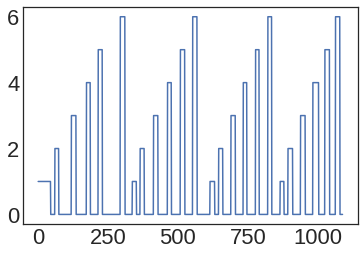

In [31]:
plt.plot(target_labels)

In [29]:
block_labels

array([ 0.,  0.,  0., ..., 47., 47., 47.])